In [3]:
import numpy as np
%matplotlib notebook
%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(18)
import tqdm
import matplotlib.animation as animation

Relu neurons

In [4]:
d = 2 # dimension of space
M = 3 # number of neurons for generation

In [5]:
def relu(x):
    if x >= 0:
        return x
    return 0.

In [6]:
def drelu(x):
    if x >= 0:
        return 1.
    return 0.

In [7]:
class Neuron:
    def __init__(self):
        a = np.random.normal()
        w = np.random.normal(size = d)
        b = np.random.normal()
        #norm = np.linalg.norm(np.concatenate([np.array([b]), w]), 2)
        #norm = np.linalg.norm(np.concatenate([np.array([a, b]), w]), 2)
        #self.a = a / norm
        self.a = a
        self.w = w #/ norm
        self.b = b #/ norm
    def set_weights(self, a, w, b):
        self.a = a
        self.w = w.copy()
        self.b = b
    def forward(self, x):
        return self.a * relu(self.w.dot(x) + self.b)

In [8]:
class Network:
    def __init__(self, width):
        self.width = width
        self.neurons = [Neuron() for i in range(width)]
    def small_sphere(self, R):
        for nr in self.neurons:
            norm = 1./R * np.linalg.norm(np.concatenate([np.array([nr.b]), nr.w]), 2)
            nr.set_weights(nr.a, nr.w/norm, nr.b/norm)
        return
    def output(self, x):
        return np.mean([n.forward(x) for n in self.neurons])
    def loss(self, x, y):
        return .5*(self.output(x) - y)**2
    def grad(self, x, y):
        d = (self.output(x) - y)
        s = np.array([relu(n.w.dot(x) + n.b) for n in self.neurons])
        ds = np.array([drelu(n.w.dot(x) + n.b) for n in self.neurons])
        ga = 1./self.width * d * s
        gb = 1./self.width * d * np.array([self.neurons[i].a*ds[i] for i in range(self.width)])
        gw = np.array([gb[i] * x for i in range(self.width)]) # shape m * d
        return ga, gw, gb
    def step(self, x, y, tau):
        ga, gw, gb = self.grad(x, y)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def batch_step(self, X, Y, tau):
        ba = X.shape[0]
        Ga, Gw, Gb = np.zeros((ba, self.width)), np.zeros((ba, self.width, d)), np.zeros((ba, self.width))
        for i in range(ba):
            Ga[i], Gw[i], Gb[i] = self.grad(X[i], Y[i])
        ga, gw, gb = Ga.mean(axis = 0), Gw.mean(axis = 0), Gb.mean(axis = 0)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def sgd_train(self, X, Y, tau, epochs, batch, disp = True):
        for e in range(epochs):
            pm = np.random.permutation(X.shape[0])
            X = np.array([X[pm[i]] for i in range(X.shape[0])])
            Y = np.array([Y[pm[i]] for i in range(Y.shape[0])])
            if batch > 1:
                nbatch = X.shape[0]//batch
                subX = np.split(X, nbatch)
                subY = np.split(Y, nbatch)
                for s in range(len(subX)):
                    self.batch_step(subX[s], subY[s], tau)
            else:
                for i in range(X.shape[0]):
                    self.step(X[i], Y[i], tau)
            loss = self.test(X, Y)
            if disp:
                print('epoch '+str(e)+' : '+str(loss))
        return loss
    def test(self, X_t, Y_t):
        ts = X_t.shape[0]
        return np.mean([self.loss(X_t[i], Y_t[i]) for i in range(ts)])
    def gen_sample(self, s = 1):
        if s==1:
            X = np.random.normal(size = d)
            Y = self.output(X)
            return X, Y
        else:
            X = np.random.normal(size = (s, d))
            Y = np.zeros(s)
            for i in range(s):
                Y[i] = self.output(X[i])
            return X, Y
    def give_weights(self):
        la, lw, lb = np.zeros(self.width), np.zeros((self.width, d)), np.zeros(self.width)
        for i in range(self.width):
            nr = self.neurons[i]
            la[i] = nr.a
            lw[i] = nr.w
            lb[i] = nr.b
        return la, lw, lb
    def display_weights(self, fig, ax, scat = None, true_w = None, color='b'):
        assert d==2, 'must be in dimension 2'
        #ax.cla()
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        la, lw, _ = self.give_weights()
        x, y = np.zeros(self.width), np.zeros(self.width)
        for k in range(self.width):
            x[k] = lw[k, 0] * la[k]
            y[k] = lw[k, 1] * la[k] 
        if scat is None:
            pos = ax.scatter(x, y, s = 10., color=color)
        else:
            scat.set_offsets(np.array([x, y]).T)
            trace = ax.scatter(x, y, s = 5., color='grey', alpha = 0.4)
        if true_w is not None:
            tla, tlw, tlb = true_w
            tx, ty = np.zeros(tla.shape[0]), np.zeros(tla.shape[0])
            for k in range(tla.shape[0]):
                tx[k] = tlw[k, 0] * tla[k]
                ty[k] = tlw[k, 1] * tla[k]
                if tx[k]>= 0:
                    u = np.linspace(0., 2., 10)
                else:
                    u = np.linspace(-2., 0., 10)
                v = ty[k]/tx[k] * u
                ax.plot(u, v, color = 'k')
            ax.scatter(tx, ty, s = 100., color='r', alpha = 0.4)
                
        if scat is None:
            fig.canvas.draw()
        

<IPython.core.display.Javascript object>


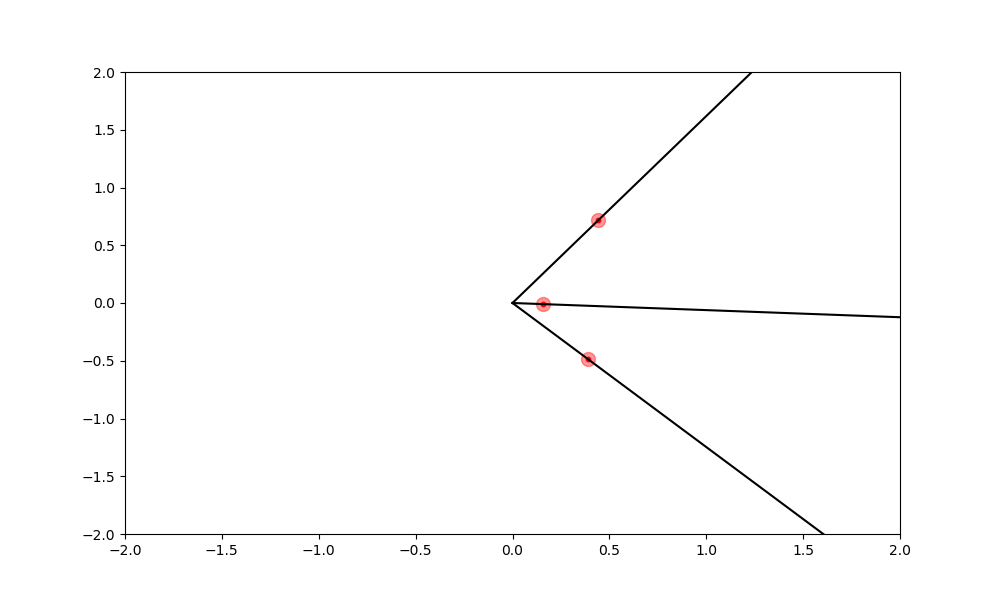

In [9]:
#np.random.seed(134)

fig, ax = plt.subplots(figsize=(10, 6))

gen_net = Network(M)

gen_net.small_sphere(2.)

true_w = gen_net.give_weights()


gen_net.display_weights(fig, ax, color='r', true_w = true_w)

Initialize new network with parameters normal on small sphere.

Train it using SGD

Trying to reproduce the visual experiment

In [10]:
net = Network(20)
net.small_sphere(10.) # the smaller the better ?

<IPython.core.display.Javascript object>


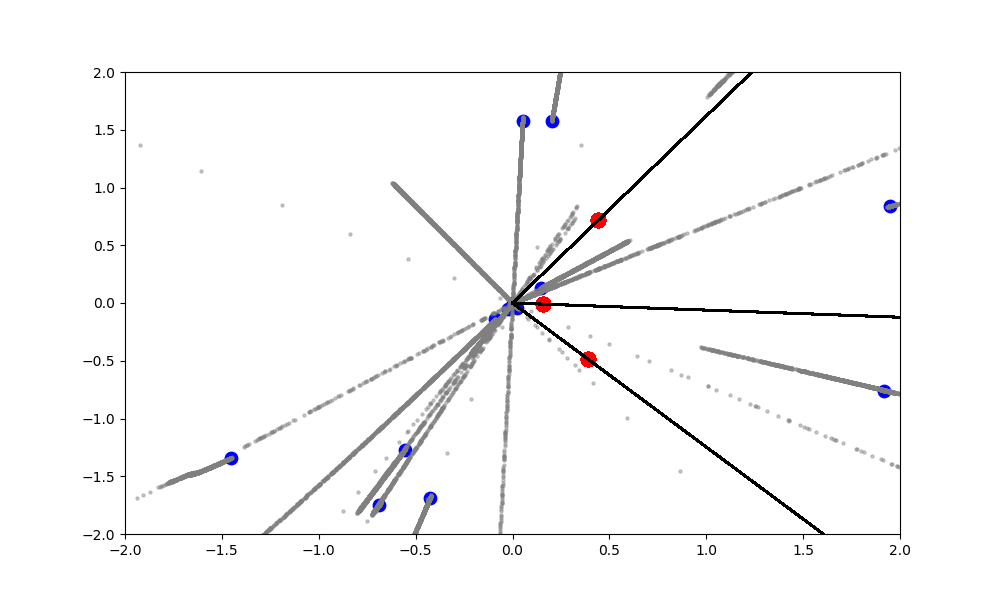

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

numframes = 500

scat = ax.scatter(None, None, s = 80., color='b')

def update_plot(i, scat, ax):
    #scat.set_array(data[i])
    print(i)
    X, Y = gen_net.gen_sample(500)
    net.sgd_train(X, Y, tau = .1, batch = 20, epochs = 1, disp = False)
    
    net.display_weights(fig, ax, scat, true_w = true_w)
    return scat,

ani = animation.FuncAnimation(fig, update_plot, frames=numframes,
                                  fargs=(scat, ax), interval = 5, blit=True)

#ani.save('./relu.gif', writer='imagemagick', fps=60, bitrate = 0.03)
#plt.show()
#fig.canvas.draw()

In [35]:
#!brew install imagemagick 

106


In [34]:
#help(ani.save)

ReLU activation function: we show for each particle the trajectory $|w(t)| \theta(t) \in R^2$
 (here = a * w). The initialization is uniformly random on a (small) sphere around 0 (this satisfies asymptotically the separation condition). This case has a homogeneous structure and is treated separately in the paper.

What is the influence of:
    - the size of the initial weights sphere ?
    - the number of units ?
    - the original problem configuration ?

<IPython.core.display.Javascript object>


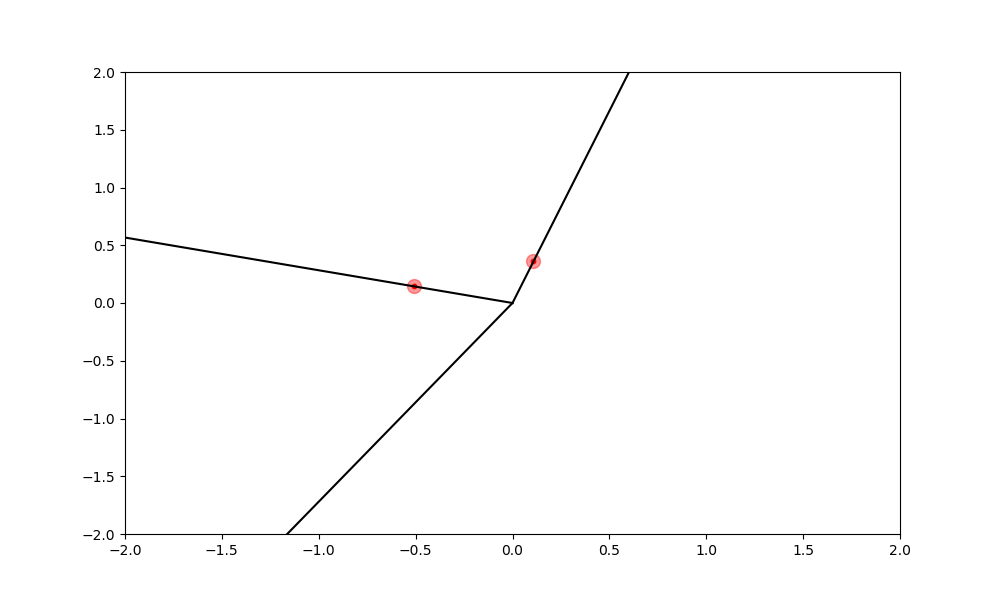

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

gen_net = Network(M)

gen_net.small_sphere(2.)

true_w = gen_net.give_weights()

gen_net.display_weights(fig, ax, color='r', true_w = true_w)

In [15]:
X_test, Y_test = gen_net.gen_sample(10000)

In [18]:
net = Network(20)
net.small_sphere(0.05) # the smaller the better ?

test_loss = []
train_loss = []
test = net.test(X_test, Y_test)
print('init', test)
for i in range(5000):
    X, Y = gen_net.gen_sample(100)
    net.sgd_train(X, Y, tau = .1, batch = 1, epochs = 1, disp = False)
    if i%10 == 0:
        test = net.test(X_test, Y_test)
        train = net.test(X, Y)
        test_loss.append(test)
        train_loss.append(train)
        print(test)

init 0.12057443009564509
0.09117217934712453
0.007637600155263116
0.0024400696312248497
0.0008160747972295844
0.00033681127535698446
0.00018162235271216017
0.00011703756719234257
8.488742088663583e-05
7.20840461110226e-05
6.376654623845535e-05
6.0383977570458855e-05
5.8780701317343456e-05
5.764622599671081e-05
5.6597224114938684e-05
5.598356463667646e-05
5.607081619868579e-05
5.563694980022436e-05
5.5227525690028744e-05
5.521108550715744e-05
5.447028283160751e-05
5.5019707849070357e-05
5.436933726373203e-05
5.508887816176247e-05
5.4159565619154935e-05
5.387005493604158e-05
5.38605339240717e-05
5.344277610961498e-05
5.382551268737793e-05
5.3501412665859615e-05
5.4255054506905975e-05
5.2886664820997565e-05
5.339843682409875e-05
5.248989140832059e-05
5.267378442658566e-05
5.231785260448374e-05
5.250173828636507e-05
5.222157746835459e-05
5.2583831575054775e-05
5.361449461380209e-05
5.189718093831607e-05


KeyboardInterrupt: 

499
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


<IPython.core.display.Javascript object>


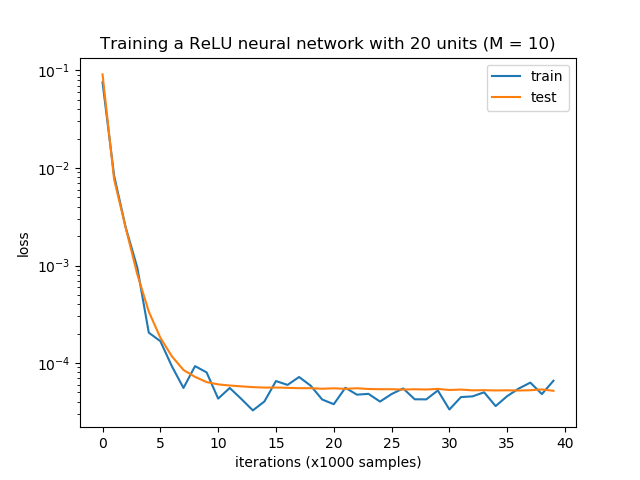

Text(0.5,1,'Training a ReLU neural network with 20 units (M = 10)')

In [19]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])
plt.xlabel('iterations (x1000 samples)')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training a ReLU neural network with 20 units (M = 10)')

In [20]:
net = Network(20)
net.small_sphere(2.) # the smaller the better ?

test_loss = []
train_loss = []
test = net.test(X_test, Y_test)
print('init', test)
for i in range(5000):
    X, Y = gen_net.gen_sample(100)
    net.sgd_train(X, Y, tau = .1, batch = 1, epochs = 1, disp = False)
    if i%10 == 0:
        test = net.test(X_test, Y_test)
        train = net.test(X, Y)
        test_loss.append(test)
        train_loss.append(train)
        print(test)

init 0.15860782255795183
0.05227125880022616
0.008452740586970485
0.003002345675757109
0.0013066219731614043
0.0006981379160231931
0.0004879619522207456
0.00039386822078299916
0.00034077627145560576
0.00031352723070906657
0.0002922066734420539
0.0002701954185127133
0.00025587144796595645
0.00024299581131093665
0.00023319373395661334
0.00022283040078525528
0.00021212360829488196
0.00020563698940936234
0.00019648120287255963
0.00020174294174431044
0.00018328520145018313
0.00017710556222997765
0.00017088531794516918
0.00016596517032158866
0.00016000930327009046
0.00015589819284569361
0.00015266461457259862
0.0001501863606151167
0.00014763903869662932
0.00014266023044038164
0.00013955260291768364
0.00013922128762837124
0.00013382780328222849
0.0001273248016981322
0.00012532820591088209
0.00012673845132603586
0.00012058656976536439
0.0001241081273910661
0.00011559195575980898
0.00011462137176295501
0.00011124807244857331
0.00010861478651590786
0.00010687105444496152
0.00010457648777889022
0

KeyboardInterrupt: 

73
74
75
76
77
78
79
80
81


<IPython.core.display.Javascript object>


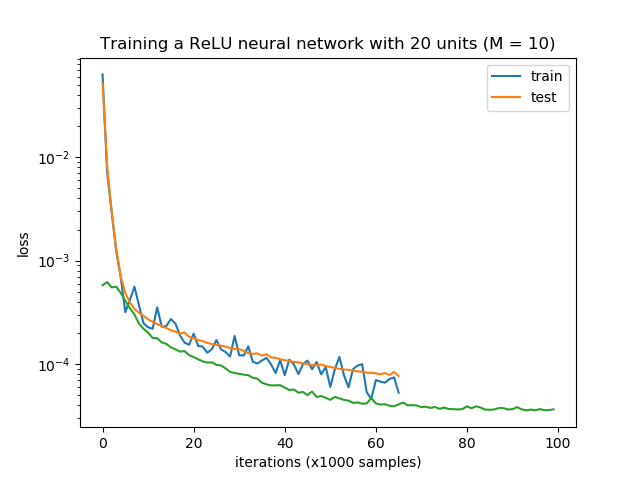

Text(0.5,1,'Training a ReLU neural network with 20 units (M = 10)')

In [21]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])
plt.xlabel('iterations (x1000 samples)')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training a ReLU neural network with 20 units (M = 10)')

In [22]:
net = Network(20)
net.small_sphere(10.) # the smaller the better ?

test_loss = []
train_loss = []
test = net.test(X_test, Y_test)
print('init', test)
for i in range(5000):
    X, Y = gen_net.gen_sample(100)
    net.sgd_train(X, Y, tau = .1, batch = 1, epochs = 1, disp = False)
    if i%10 == 0:
        test = net.test(X_test, Y_test)
        train = net.test(X, Y)
        test_loss.append(test)
        train_loss.append(train)
        print(test)

init 1.4277478212547774
0.02980520126456416
0.004811598322232711
0.0037922386634834026
0.003309757307531026
0.0022283348287225396
0.0027495454403787313
0.001582300466385598
0.0014502608549621415
0.0022145089451030896
0.0011593533165681607
0.001031956338040984
0.0009769702532401127
0.0009611824484228742
0.006085175861845016
0.0008370147998961752
0.0008429631024522621
0.000787243008992336
0.0007232286324185042
0.0007919922242186756
0.00367732517544896
0.0006490974914090872
0.0006537839814581501
0.0006027434961733445
0.0006767077271632773
0.0005661160497697157
0.0005670659306695311
0.0005523572560667538
0.0005420393637261503
0.0005306512650225874
0.0005239759583541033
0.0005198868689244696
0.0005045964040977381
0.0004971552461041028
0.00046115818945807925
0.00046630091186550834
0.00048987027646702
0.000443399616925467
0.0004137061406738683
0.0005136398440195343
0.00043773408598850495
0.000418811035516498
0.0004667558682502087
0.00045247873146510564
0.0004260373748195061
0.0004758885371597

KeyboardInterrupt: 

176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195


<IPython.core.display.Javascript object>


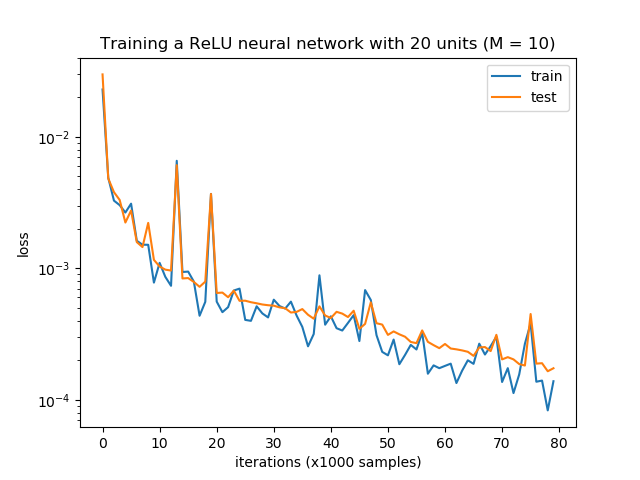

Text(0.5,1,'Training a ReLU neural network with 20 units (M = 10)')

In [23]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])
plt.xlabel('iterations (x1000 samples)')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training a ReLU neural network with 20 units (M = 10)')

In [24]:
net = Network(20)
net.small_sphere(.001) # the smaller the better ?

test_loss = []
train_loss = []
test = net.test(X_test, Y_test)
print('init', test)
for i in range(5000):
    X, Y = gen_net.gen_sample(100)
    net.sgd_train(X, Y, tau = .1, batch = 1, epochs = 1, disp = False)
    if i%10 == 0:
        test = net.test(X_test, Y_test)
        train = net.test(X, Y)
        test_loss.append(test)
        train_loss.append(train)
        print(test)

init 0.12244439473916448
0.09190369616344785
0.00877828612133312
0.0031311213474432466
0.001168745627490247
0.0005251965923237299
0.0002650484332682594
0.00014486690659501478
9.562913769532732e-05
7.584858688975913e-05
6.347831346744523e-05
5.8471938972451675e-05
5.663223399295497e-05
5.433890585399785e-05
5.5180389343535355e-05
5.390449946070179e-05
5.332675331737673e-05
5.296497751145669e-05
5.333328863350381e-05
5.270165298468492e-05
5.261663088724041e-05
5.239637851359886e-05
5.215830914851402e-05
5.240342497216907e-05
5.225324105444018e-05
5.301101625378002e-05
5.203709760000738e-05
5.2135598588326795e-05
5.202085956620515e-05
5.157524155469142e-05
5.212954022756715e-05
5.135255902931633e-05
5.134697073735947e-05
5.172953753923998e-05
5.1264019120819405e-05
5.2982520559183346e-05
5.114039853757722e-05
5.107356707602102e-05
5.144361430664612e-05
5.1752536834083495e-05
5.1464079437916965e-05
5.384462336539275e-05
5.1717091536679705e-05
5.114129515460297e-05
5.115319459589746e-05
5.0

KeyboardInterrupt: 

241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490


In [16]:
ray = [1e-3, 5e-2, 2., 10.]
reps = 5
losses = np.zeros((len(ray), reps, 100))

for rep in tqdm.tqdm(range(reps)):
    gen_net = Network(M)
    gen_net.small_sphere(2.)
    Xt, Yt = gen_net.gen_sample(10000)
    for ri in range(len(ray)):
        r = ray[ri]
        net = Network(20)
        net.small_sphere(r)
        
        for k in range(100):
            X, Y = gen_net.gen_sample(500)
            train_loss = net.sgd_train(X, Y, tau = .5, batch = 1, epochs = 1, disp = False)
            
            losses[ri, rep, k] = net.test(Xt, Yt)
            print('test', losses[ri, rep, k])
        net = []
        print(r)

  0%|          | 0/5 [00:00<?, ?it/s]

test 0.0007717706173508378
test 0.0003301948011530962
test 0.00020604429834006552
test 0.00015183060926025007
test 0.00013255627826522034
test 9.140317050805778e-05
test 5.8780942707594885e-05
test 4.3036795565924526e-05
test 3.192137066580576e-05
test 2.37920995811887e-05
test 1.9107253269289027e-05
test 1.493535416645136e-05
test 1.3069108362756954e-05
test 1.0489859164471898e-05
test 8.055975379610547e-06
test 6.566897209482025e-06
test 5.822599718212322e-06
test 4.9525655093087706e-06
test 4.20570392604647e-06
test 3.512974591678416e-06
test 3.0880884895751224e-06
test 2.6301832492308562e-06
test 2.115335460897514e-06
test 1.9412647301079104e-06
test 1.7213115167716203e-06
test 1.3614941708423845e-06
test 1.2939284706700003e-06
test 1.0221723630538153e-06
test 1.0179264463701894e-06
test 8.025560276858246e-07
test 7.158056231053158e-07
test 6.27739278799016e-07
test 5.65987104626969e-07
test 5.158875813878787e-07
test 4.683354918083332e-07
test 4.2500569804266344e-07
test 4.2744952

test 2.465759872080242e-05
2.0
test 0.07468721623183634
test 0.001261634513145429
test 0.0020783412443387624
test 0.001210561167632085
test 0.002885473455810263
test 0.0021288073573857594
test 0.009760794720716141
test 0.010478723106214794
test 0.0018304170685583137
test 0.0008847603601045751
test 0.0033973871929261256
test 0.0011407680592685767
test 0.0024415379963196233
test 0.0013423044794348162
test 0.00044317320925955423
test 0.0010823760555998497
test 0.0013687214037518263
test 0.00169739641640719
test 0.0009639526075919795
test 0.0005177409525616024
test 0.0016347484725481767
test 0.0005755713109471084
test 0.0008541071644197048
test 0.000889696757392651
test 0.0004951937423722264
test 0.00044053497283826743
test 0.0006826704692600257
test 0.008393039689762368
test 0.0006801811745677788
test 0.00029769620006548264
test 0.001592326478448713
test 0.0006117013969319843
test 0.0015475790346622495
test 0.005755522775612193
test 0.006097452225408289
test 0.001996275196021039
test 0.00

 20%|██        | 1/5 [04:42<18:49, 282.45s/it]

test 0.00047624816464369
10.0
test 0.0013574683176401869
test 0.0002968041519722824
test 0.00025573690270256895
test 0.00011101914585733645
test 7.991589222610064e-05
test 6.397261854627609e-05
test 5.2629621156864856e-05
test 4.993933457704518e-05
test 4.386059817525989e-05
test 4.420083171920953e-05
test 3.932351377742919e-05
test 4.0551397355848005e-05
test 3.8237858462702895e-05
test 3.657774384957141e-05
test 4.353385447219703e-05
test 3.7589232098718725e-05
test 3.59352711617477e-05
test 4.9997331830505527e-05
test 4.053614764176181e-05
test 3.797733292720515e-05
test 3.652068667001635e-05
test 3.831795126692994e-05
test 3.637272688723763e-05
test 3.4264005650581466e-05
test 3.627868588031574e-05
test 3.551808173715059e-05
test 3.783230389218856e-05
test 3.371530712637633e-05
test 3.408994360181585e-05
test 3.748823515524839e-05
test 3.357510744193737e-05
test 3.5524350229193046e-05
test 5.819055465437012e-05
test 5.182501830395201e-05
test 3.4388001105966884e-05
test 3.260406166

test 1.2086447018059627e-05
test 1.2448696028041192e-05
2.0
test 0.011383479477160197
test 0.01695842649815919
test 0.011583485976140099
test 0.003699034067178927
test 0.0023385208382485133
test 0.0013033670915608743
test 0.0021612497522287685
test 0.010081475637885563
test 0.0018022341009469684
test 0.001097129578544919
test 0.0015468376800534852
test 0.0013739419455972661
test 0.0022626259626258327
test 0.0009494585103231076
test 0.0007295497103606234
test 0.0011262640057964667
test 0.021266921701721318
test 0.0018379247888328128
test 0.0010432420391734297
test 0.0013490758154037802
test 0.003034132489174692
test 0.0006211041363827619
test 0.000815023893119761
test 0.0006795568971993734
test 0.0010983663390466453
test 0.0008246456203202946
test 0.0008668095828656845
test 0.0011189358189325196
test 0.0007655103516049442
test 0.0038732168034530134
test 0.0004674746650152829
test 0.0005170800461707692
test 0.0005239674848484598
test 0.0004334112048359895
test 0.0005277146630004642
test 

 40%|████      | 2/5 [09:36<14:17, 285.95s/it]

test 0.0002482903299040927
10.0
test 0.006716235142044012
test 0.005029068499332602
test 0.004506872277209615
test 0.004257917492744233
test 0.0042428138312274885
test 0.004043381377225646
test 0.003928565947813759
test 0.0038679985280988703
test 0.0038358517607820575
test 0.003824278753467067
test 0.0038122522659020043
test 0.0038147284833064165
test 0.0038023636427519754
test 0.003839140713274348
test 0.00379058560193147
test 0.0037890408758235196
test 0.0038006438732082048
test 0.0037938290368885637
test 0.0038153279244094703
test 0.0037852300553184305
test 0.0038066785893409675
test 0.00379068777739528
test 0.003783332922593154
test 0.003794061753900804
test 0.0037869631419362028
test 0.0037861230258106004
test 0.0037843125891441056
test 0.0037959589579176834
test 0.0037810662617923313
test 0.0037844438468958453
test 0.0037819739559037282
test 0.0037831650290351534
test 0.003856042889639651
test 0.0037844718401751267
test 0.003785604656523857
test 0.0037835540369097857
test 0.00378

test 0.0020759506547832368
test 0.0013091205805712094
test 0.0022583276100668188
test 0.0016928267125965216
test 0.0014114734473333077
test 0.0013485070430990275
test 0.0013752823254761495
test 0.02846902296419919
test 0.0012625826193729032
test 0.0009457579182467428
test 0.005220547066663152
test 0.0006995480240277481
test 0.0010665287785687457
test 0.0009274099144672426
test 0.0005933533641867541
test 0.0011884117197534896
test 0.0007118872769327498
test 0.0011219981455922064
test 0.0008470956069402734
test 0.0005606209019320033
test 0.0023858303964915447
test 0.0007277631534911552
test 0.0021417740903301326
test 0.003942527474803422
test 0.0009262066785967397
test 0.008657895027366337
test 0.0005909678878511404
test 0.00048582333419422365
test 0.0023141105597023716
test 0.0006974141376722341
test 0.0005302056473509482
test 0.0004995103929526999
test 0.0005794109118907429
test 0.0008385443566722732
test 0.0008421093156396999
test 0.0011119038686918212
test 0.0012617040640179975
test 

 60%|██████    | 3/5 [14:13<09:26, 283.35s/it]

test 0.00046019672652212947
10.0
test 0.004866294710457923
test 0.0015370237025030026
test 0.0007366478047376549
test 0.0003100614812991659
test 0.00018367425423219488
test 0.00012109722089705421
test 9.433253290492478e-05
test 7.790260342210879e-05
test 7.126432309651249e-05
test 6.372007777603714e-05
test 5.763141959315644e-05
test 5.389996966488891e-05
test 4.9662302912878937e-05
test 4.793795389815992e-05
test 4.560172332424276e-05
test 4.275081201858296e-05
test 4.0759316081245366e-05
test 3.76146309034526e-05
test 3.4621653558068686e-05
test 3.301142354016431e-05
test 3.232097224712922e-05
test 2.915282740853913e-05
test 2.693644240645454e-05
test 2.574106200377525e-05
test 2.480977281269348e-05
test 2.4030344649372408e-05
test 2.2981642828777065e-05
test 2.2081634501055762e-05
test 2.1273717684988276e-05
test 2.0778127123382343e-05
test 2.0048901823484808e-05
test 1.9353614881324187e-05
test 1.8711988414375996e-05
test 1.7925782975011275e-05
test 1.7487620224309598e-05
test 1.69

test 8.215370273991628e-06
test 8.150857547096984e-06
test 2.3010055914636333e-05
2.0
test 0.003193296479460892
test 0.002296106299411407
test 0.011373553109460985
test 0.07221778340636428
test 0.002624448552461344
test 0.0037571110520470334
test 0.006964506019049006
test 0.0011452955264011871
test 0.001493858494744866
test 0.001575361764597308
test 0.0013248084393625143
test 0.0010112392348371247
test 0.0011069720578129243
test 0.002174692512372417
test 0.0009685357023106047
test 0.0009610503697648703
test 0.00099214646024717
test 0.0006493358763126781
test 0.0010127707651734841
test 0.0004806199938143748
test 0.0004802427086729603
test 0.0027240127477434267
test 0.0005492042685235582
test 0.0004885591077839212
test 0.00041959181363043926
test 0.0016670215044398504
test 0.002225003013001374
test 0.0013189798300360716
test 0.0007594462553009161
test 0.00025840870084635064
test 0.00024693378126306673
test 0.0072738303898635765
test 0.00029265160071850787
test 0.0002331866562926988
test 

 80%|████████  | 4/5 [18:48<04:40, 280.81s/it]

test 2.6672291668122917e-05
10.0
test 0.0004003167106571615
test 0.00033703652839026636
test 0.0003352151894916792
test 0.00031032334547221186
test 0.00028519139431385583
test 0.00020045445444500753
test 8.833859310844108e-05
test 7.673024281645388e-05
test 6.948485047406524e-05
test 6.792240522800446e-05
test 7.014911389307736e-05
test 6.790080551380862e-05
test 6.661966632495087e-05
test 6.219825957010126e-05
test 6.75097457278108e-05
test 6.047713213068792e-05
test 9.723805294529e-05
test 6.90422878158551e-05
test 6.510204234850132e-05
test 5.82369514530719e-05
test 6.345542995340144e-05
test 5.644141036223841e-05
test 6.05519637598813e-05
test 5.8117514678409896e-05
test 5.637792758686141e-05
test 5.8829542454636753e-05
test 6.0071420086646744e-05
test 5.388293300614715e-05
test 5.224749964231996e-05
test 5.96619690001435e-05
test 5.8461796668709695e-05
test 5.7515250606790224e-05
test 5.095103762666607e-05
test 5.224811595711538e-05
test 4.969808983023344e-05
test 6.09522912020414

test 1.3002050125722865e-05
test 1.0247891372495152e-05
2.0
test 0.3179165344068869
test 0.038142976883885606
test 0.00771302761425606
test 0.05560426552644819
test 0.023773072155583556
test 0.005099832620108859
test 0.01878912604376508
test 0.00643125286117934
test 0.008153832554429715
test 0.004411346530837535
test 0.007270544022282924
test 0.03538797318222935
test 0.007248814803354709
test 0.006025299605115829
test 0.005252947160987253
test 0.002891228983142375
test 0.037436040761710185
test 0.0024899884305370173
test 0.0021697205955114674
test 0.0027583979622854186
test 0.0027336904268526526
test 0.006425108533533069
test 0.006638138922885199
test 0.0026005537430606085
test 0.0044082754493863854
test 0.0019114286088497206
test 0.0034340637831381036
test 0.0023802038378607213
test 0.0025678970790971732
test 0.0019030003450163978
test 0.0017937552727270987
test 0.0013703281574998112
test 0.0013649513797080292
test 0.0017328803400538013
test 0.001004482509417558
test 0.001842897362875

100%|██████████| 5/5 [23:27<00:00, 280.19s/it]

test 3.700743509051654e-05
10.0


In [17]:
losses

array([[[7.71770617e-04, 3.30194801e-04, 2.06044298e-04, ...,
         1.26930202e-07, 1.26817838e-07, 1.37953121e-07],
        [1.35746832e-03, 2.96804152e-04, 2.55736903e-04, ...,
         1.62039229e-05, 1.59353977e-05, 1.49752755e-05],
        [6.71623514e-03, 5.02906850e-03, 4.50687228e-03, ...,
         3.77639496e-03, 3.77950329e-03, 3.76551154e-03],
        [4.86629471e-03, 1.53702370e-03, 7.36647805e-04, ...,
         1.41206609e-06, 1.39729099e-06, 1.42924841e-06],
        [4.00316711e-04, 3.37036528e-04, 3.35215189e-04, ...,
         3.97207217e-05, 3.48885103e-05, 3.88156472e-05]],

       [[6.77756857e-04, 2.49373558e-04, 1.61432822e-04, ...,
         9.20590236e-07, 8.60423515e-07, 8.04889650e-07],
        [1.47744884e-03, 4.01459799e-04, 2.10835053e-04, ...,
         2.26749941e-05, 2.02890611e-05, 2.17815325e-05],
        [4.13351740e-03, 1.93804563e-03, 1.28037325e-03, ...,
         6.63832339e-08, 6.57569091e-08, 6.54268645e-08],
        [7.38899212e-03, 2.69049721e-0

In [18]:
output = open('data.pkl', 'wb')

# Pickle using protocol 0.
pickle.dump(losses, output)


In [50]:
def lineplotCI(x, y, low, up, alp = 0.2):
    plt.plot(x, y, lw = 2, alpha = 1)
    plt.fill_between(x, low, up, alpha = alp)

In [51]:
losses

array([[[7.71770617e-04, 3.30194801e-04, 2.06044298e-04, ...,
         1.26930202e-07, 1.26817838e-07, 1.37953121e-07],
        [1.35746832e-03, 2.96804152e-04, 2.55736903e-04, ...,
         1.62039229e-05, 1.59353977e-05, 1.49752755e-05],
        [6.71623514e-03, 5.02906850e-03, 4.50687228e-03, ...,
         3.77639496e-03, 3.77950329e-03, 3.76551154e-03],
        [4.86629471e-03, 1.53702370e-03, 7.36647805e-04, ...,
         1.41206609e-06, 1.39729099e-06, 1.42924841e-06],
        [4.00316711e-04, 3.37036528e-04, 3.35215189e-04, ...,
         3.97207217e-05, 3.48885103e-05, 3.88156472e-05]],

       [[6.77756857e-04, 2.49373558e-04, 1.61432822e-04, ...,
         9.20590236e-07, 8.60423515e-07, 8.04889650e-07],
        [1.47744884e-03, 4.01459799e-04, 2.10835053e-04, ...,
         2.26749941e-05, 2.02890611e-05, 2.17815325e-05],
        [4.13351740e-03, 1.93804563e-03, 1.28037325e-03, ...,
         6.63832339e-08, 6.57569091e-08, 6.54268645e-08],
        [7.38899212e-03, 2.69049721e-0

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

<IPython.core.display.Javascript object>


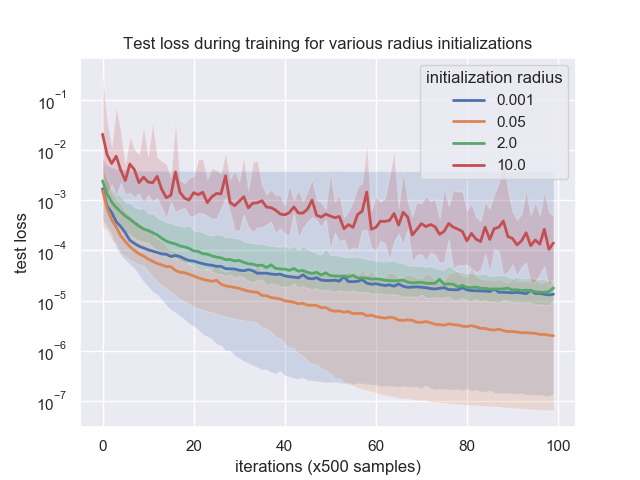

In [71]:
plt.figure()

"""
plt.plot(range(100), np.exp(np.mean(np.log(losses[0, :, :]), axis = 0)))
plt.plot(range(100), np.exp(np.mean(np.log(losses[1, :, :]), axis = 0)))
plt.plot(range(100), np.exp(np.mean(np.log(losses[2, :, :]), axis = 0)))
plt.plot(range(100), np.exp(np.mean(np.log(losses[3, :, :]), axis = 0)))
"""

for iray in range(4):
    x = range(100)
    y = np.exp(np.mean(np.log(losses[iray, :, :]), axis = 0))
    ma = np.exp(np.max(np.log(losses[iray, :, :]), axis = 0))
    mi = np.exp(np.min(np.log(losses[iray, :, :]), axis = 0))
    lineplotCI(x = x, y = y, low = mi, up=ma, alp = 0.2)

plt.legend([1e-3, 5e-2, 2., 10.], title='initialization radius')
plt.xlabel('iterations (x500 samples)')
plt.ylabel('test loss')
#plt.ylim((1e-6, 1e0))
plt.yscale('log')
plt.title('Test loss during training for various radius initializations')
plt.show()

In [44]:
print(losses)

0
[[[5.78698783e-04 6.19952643e-04 5.51100332e-04 ... 3.56749272e-05
   3.57773676e-05 3.63895646e-05]
  [6.32755477e-03 5.58625014e-03 4.68214922e-03 ... 1.48432931e-07
   1.40700055e-07 2.87942641e-07]
  [3.55126788e-03 3.00792385e-03 2.49856526e-03 ... 8.54173121e-05
   9.72682266e-05 2.63587310e-04]
  [1.26908491e-02 1.45930563e-03 1.17760863e-03 ... 6.25284624e-05
   5.95414596e-05 6.11791837e-05]
  [1.36143084e-02 5.38116823e-03 3.73041065e-03 ... 3.46169457e-03
   3.46092980e-03 3.46194858e-03]]

 [[4.98935196e-04 4.19807271e-04 3.44342282e-04 ... 7.68235162e-06
   9.14981757e-06 7.73657114e-06]
  [5.84440705e-03 2.03350300e-03 1.13669242e-03 ... 4.36431390e-08
   4.25326493e-08 4.01492252e-08]
  [3.88121816e-03 3.71527981e-03 3.28827297e-03 ... 1.28290794e-04
   1.05410411e-04 1.07483989e-04]
  [2.31185341e-02 4.02762577e-03 1.41020384e-03 ... 7.29785863e-06
   6.98573581e-06 6.81219082e-06]
  [1.11954884e-02 1.84834644e-03 2.19133291e-04 ... 3.92671133e-07
   3.85418144e-07 3.

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [45]:
import pickle
#losses.dump('data.pkl')

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [8]:
f = open('data.pkl', 'rb')

losses = pickle.load(f)

EOFError: Ran out of input

In [9]:
losses

NameError: name 'losses' is not defined